## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2023.

## Assignment 2 - Task 1: Optimization

In this task, we introduce several improved optimization algorithms based on stochastic gradient descent (SGD). Naive SGD is a reasonable method to update neural network parameters. However, there exists two main drawbacks:

- First, to make SGD perform well, one would need to find an appropriate learning rate and good initial values for the prameters. The training will progress slowly if the learning rate is small, or diverge if the learning rate is too large. Since we often have no prior knowledge about the training data in reality, it is not trivial to find a good learning rate by hand. Also, when the network grows deeper, one may need to set a different learning rate for each layer. 

- Second, SGD strictly follows the gradients of the **batched data** when updating the parameters. This can be problematic with real-world problems as has been demonstrated in the lectures.

To seek for improvements of naive SGD, momentum, parameter estimation and adaptive learning rate methods are commonly the ones to rely on. Here, you are going to experiment with **SGD with Momentum**, **SGD with Nesterov-accelorated Momentum**, **Adam**, **SGD with Backtracing Line Search** and compare their performances.

Consult the slides and [text book](https://www.deeplearningbook.org) for details. Here is also [a useful link](http://ruder.io/optimizing-gradient-descent/) to learn more about some methods used in this task.

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Import modules
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Fashion-MNIST

Here we use a small dataset with only 2500 samples to simulate the "lack-of-data" situation.

In [5]:
# Load the raw Fashion-MNIST data.
train, val = fashion_mnist.load_data()

X_train_raw, y_train = train
X_val_raw, y_val = val

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_val = X_val_raw.reshape((X_val_raw.shape[0], X_val_raw.shape[1]**2))

#Consider a subset of 2500 samples of the 60000 total images (indexed 10000 ~ 12500)
X_val = X_train[10000:10500,:]
y_val = y_train[10000:10500]
X_train = X_train[10500:12500,:]
y_train = y_train[10500:12500]

mean_image = np.mean(X_train, axis=0).astype(np.float32)
X_train = X_train.astype(np.float32) - mean_image
X_val = X_val.astype(np.float32) - mean_image

# We have vectorized the data for you
# Flatten the 32×32×3 images into 1×3072 Numpy arrays
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Training data shape:  (2000, 784)
Training labels shape:  (2000,)
Validation data shape:  (500, 784)
Validation labels shape:  (500,)


## Part 1: Implement Several Optimizers (16%)

Instructors provide code snippets for testing student code implementations.

The best anticipated achievable accuracies are specific to each algorithm. You may judge from the the accuracies to check your implementations.

In [16]:
from utils.neuralnets.mlp import MLP

### Basics

Assume that the goal is to optimize an objective function $L$ parametrized by network weights $\theta \in R^d$, the update rule of an iterative optimization algorithm in general can be formulated as

$$\theta_{t+1} \gets \theta_t + \alpha_t p_t$$

where $\alpha_t > 0$ is the **step size** and $p$ is the **direction of update**. 

Both $\alpha$ and $p$ can be proposed in numerous different ways which result in different optimizers with different performances.

Note that in the following equations, we ***DO NOT*** take learning rate decay into consideration. This has been implemented in the base class `Optimizer.train()`. All optimizers will be derived from this class.

### Original SGD (For Comparison)

At time step $t$, let the gradient of a real-valued loss function $L$ w.r.t network parameter $\theta$ be given by

$$g_t = \nabla_{\theta_t} L(\theta_t)$$

and $\theta_t$ denotes the values of the parameters at time $t$.

As you have seen in previous examples, the loss $L$ is calculated from a mini-batch stochastically sampled from the entire dataset.

SGD (Stochastic Gradient Descent) algorithm is formulated as

$$\theta_{t+1} = \theta_t - \eta g_t$$

where $\eta$ is the ***learning rate***. 

The final accuracy you should expect is arround 0.1-0.3. 

In [18]:
from utils.optimizers import SGDOptim

model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[100, 100],
    num_classes=10, weight_scale=1e-3, l2_reg=0.0
)
optimizer = SGDOptim(model)
hist_sgd = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=15, batch_size=200, learning_rate=1e-2, learning_decay=0.95, 
    verbose=False, record_interval=1
)

number of batches for training: 10
epoch 1: valid acc = 0.116, new learning rate = 0.0095, number of evaluations 12
epoch 2: valid acc = 0.192, new learning rate = 0.009025, number of evaluations 12
epoch 3: valid acc = 0.194, new learning rate = 0.00857375, number of evaluations 12
epoch 4: valid acc = 0.198, new learning rate = 0.0081450625, number of evaluations 12
epoch 5: valid acc = 0.206, new learning rate = 0.007737809374999999, number of evaluations 12
epoch 6: valid acc = 0.2, new learning rate = 0.007350918906249998, number of evaluations 12
epoch 7: valid acc = 0.202, new learning rate = 0.006983372960937498, number of evaluations 12
epoch 8: valid acc = 0.206, new learning rate = 0.006634204312890623, number of evaluations 12
epoch 9: valid acc = 0.2, new learning rate = 0.006302494097246091, number of evaluations 12
epoch 10: valid acc = 0.2, new learning rate = 0.005987369392383786, number of evaluations 12
epoch 11: valid acc = 0.204, new learning rate = 0.0056880009227

### Method 1: Find A Better Direction

As naively in SGD, the step size $\alpha_t = \eta$ is fixed to be the learning rate and the update direction $p_t = -g_t$ is simply the opposite of the gradient. Now let's look at some algorithms that try to use a different $p$. 

#### SGD + Momentum

All gradient methods share the disadvantage of being stuck by local minima. Momentum is one possible way out. By accumulating previous "velocities" of update, the algorithm can potentially jump out of a local minima and give faster convergence.

The algorithm is formulated as two steps:
1. Accumulate the **velocities**:
   $$v_t = \beta v_{t-1} + g_t$$
2. Update the parameters:
   $$\theta_{t+1} = \theta_t - \eta v_t$$

where $\beta \in [0, 1]$ is the decay factor controlling the effect of past velocities on the current update and $v_0$ is initialized to be $\mathbb{0}$.

The intuition is to modify the current update direction (naively $g_t$ in SGD) by accumulated past directions. You can think of it as rolling a heavy ball down the hill, where the inertia of the ball will always try to retain the direction of the current velocity instead of simply following the slope.

The final accuracy you should expect is arround 0.5-0.7. 

<span style="color:red">__TODO:__</span> Implement SGD + Momentum by editing `SGDmomentumOptim` in **./utils/optimizers.py**

In [22]:
# Verification code for your implemention
# Please don't change anything.

from utils.optimizers import SGDMomentumOptim

model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[100, 100],
    num_classes=10, weight_scale=1e-3, l2_reg=0.0
)
optimizer = SGDMomentumOptim(model, momentum=0.8)
hist_sgd_momentum = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=15, batch_size=200, learning_rate=1e-2, 
    learning_decay=0.95, verbose=False, record_interval=1
)

number of batches for training: 10
epoch 1: valid acc = 0.116, new learning rate = 0.0095, number of evaluations 12
epoch 2: valid acc = 0.194, new learning rate = 0.009025, number of evaluations 12
epoch 3: valid acc = 0.194, new learning rate = 0.00857375, number of evaluations 12
epoch 4: valid acc = 0.194, new learning rate = 0.0081450625, number of evaluations 12
epoch 5: valid acc = 0.2, new learning rate = 0.007737809374999999, number of evaluations 12
epoch 6: valid acc = 0.208, new learning rate = 0.007350918906249998, number of evaluations 12
epoch 7: valid acc = 0.202, new learning rate = 0.006983372960937498, number of evaluations 12
epoch 8: valid acc = 0.2, new learning rate = 0.006634204312890623, number of evaluations 12
epoch 9: valid acc = 0.206, new learning rate = 0.006302494097246091, number of evaluations 12
epoch 10: valid acc = 0.198, new learning rate = 0.005987369392383786, number of evaluations 12
epoch 11: valid acc = 0.192, new learning rate = 0.00568800092

#### SGD + Nesterov-accelorated Momentum

While momentum shows exciting results for an algorithm as simple as above, the convergence rate can be further improved by introducing the Nesterov acceloration.

As an intuition, the previous algorithm only modify the parameters using the momentum at the **current** time step $v_t$. Nesterov proposed to derive an estimation of the momentum at the **next** time step $\hat v_{t+1}$ to perform the update.

This translates to the following algorithm:
1. Accumulate the velocities:
   $$v_t = \beta v_{t-1} + g_t$$
2. **Nesterov acceloration**:
   $$\hat v_{t+1} = \beta v_t + g_t$$
3. Update the parameters:
   $$\theta_{t+1} = \theta_t - \eta \hat v_{t+1}$$

The final accuracy you should expect is arround 0.7-0.9. 

<span style="color:red">__TODO:__</span> Implement SGD + Momentum by editing `SGDmomentumOptim` in **./utils/optimizers.py**

In [23]:
# Verification code for your implemention
# Please don't change anything.

from utils.optimizers import SGDNestMomentumOptim

model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[100, 100],
    num_classes=10, weight_scale=1e-3, l2_reg=0.0
)
optimizer = SGDNestMomentumOptim(model, momentum=0.9)
hist_sgd_nesterov = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=15, batch_size=200, learning_rate=1e-2, 
    learning_decay=0.95, verbose=False, record_interval=1
)

number of batches for training: 10
epoch 1: valid acc = 0.166, new learning rate = 0.0095, number of evaluations 12
epoch 2: valid acc = 0.198, new learning rate = 0.009025, number of evaluations 12
epoch 3: valid acc = 0.21, new learning rate = 0.00857375, number of evaluations 12
epoch 4: valid acc = 0.216, new learning rate = 0.0081450625, number of evaluations 12
epoch 5: valid acc = 0.24, new learning rate = 0.007737809374999999, number of evaluations 12
epoch 6: valid acc = 0.306, new learning rate = 0.007350918906249998, number of evaluations 12
epoch 7: valid acc = 0.36, new learning rate = 0.006983372960937498, number of evaluations 12
epoch 8: valid acc = 0.382, new learning rate = 0.006634204312890623, number of evaluations 12
epoch 9: valid acc = 0.462, new learning rate = 0.006302494097246091, number of evaluations 12
epoch 10: valid acc = 0.586, new learning rate = 0.005987369392383786, number of evaluations 12
epoch 11: valid acc = 0.628, new learning rate = 0.0056880009

#### Adam

With the algorithm above, we're already implying the notion of **[moment](https://en.wikipedia.org/wiki/Moment_(mathematics)) estimation** (i.e. $\hat v_{t+1}$) in the sense of Nesterov by combining current gradient and exponetially decaying past gradients (with factor $\beta$). Here we explore another more flexible and widely used estimation method - the **moving average**.

For any time series denoted by $x_0, x_1, \dots, x_t$, its moving average at time $t$ is defined iteratively as a weighted summation of the previous average and current value, i.e.

$$\mu_t = \beta \mu_{t-1} + (1 - \beta) x_t$$

where the hyperparameter $\beta \in [0, 1]$ is the decay factor controlling the influence of the past to the present. This provides the algorithm with better adaptations to the change of parameters through time.

Naturally, we would want to know *statistically* how far our moving average $\mu_t$ deviates from the true average $\mu$ by considering its expectation $\mathbb{E}[\mu_t]$.

Specifically, the moving average can be expanded (by plugging in each $\mu_t$) to

$$\mu_t = (1 - \beta) \sum_{i=1}^t \beta^{t-i} x_i$$

Then

$$
\mathbb{E}[\mu_t]
= \mathbb{E} \left[ (1 - \beta) \sum_{i=1}^t \beta^{t-i} x_i \right]
= (1 - \beta) \sum_{i=1}^t \beta^{t-i} \mathbb{E}[x_i]
$$

Assume that the series elements are identically distributed (i.e. $\mathbb{E}[x_1] = \dots = \mathbb{E}[x_t] = \mu$), then

$$\mathbb{E}[\mu_t] = \mu (1 - \beta) \sum_{i=1}^t \beta^{t-i} = (1 - \beta^t) \mu$$

Therefore, a bias-corrected moving average can be given by

$$\hat \mu_t = \frac{\mu_t}{1 - \beta^t}$$

With all the discussions above, Adam (Adaptive Moment Estimation) algorithm can be formulated into three following steps.

**1. Moment calculation**
   - The 1st moment (**mean**) of the gradients:
     $$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$$
   - The 2nd moment (**variance**) of the gradients:
     $$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$$

**2. Bias correction**

   - Adjust the 1st moment:
   $$\hat m_t = \frac{m_t}{1 - \beta_1^t}$$
   - Adjust the 2nd moment:
   $$\hat v_t = \frac{v_t}{1 - \beta_2^t}$$

**3. Parameter update**

   $$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat v_t}+\epsilon} \odot \hat m_t$$

   Here, $\epsilon$ is a small value (e.g. 1e-8) serves to avoid zero-division and $\odot$ denotes the Hadamard (element-wise) product.

The final accuracy you should expect is arround 0.8-0.9. 

**This is usually (not always) the optimal choice in practice.**

<span style="color:red">__TODO:__</span> Implement Adam by editing `AdamOptim` in **./utils/optimizers.py**

In [31]:
# Verification code for your implemention
# Please don't change anything.

from utils.optimizers import AdamOptim

model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[100, 100],
    num_classes=10, weight_scale=1e-3, l2_reg=0.0
)
optimizer = AdamOptim(model, beta1=0.9, beta2=0.99)
hist_adam = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=15, batch_size=200, learning_rate=1e-3, 
    learning_decay=0.95, verbose=False, record_interval=1
)

[autoreload of utils.optimizers failed: Traceback (most recent call last):
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name

number of batches for training: 10
epoch 1: valid acc = 0.2, new learning rate = 0.00095, number of evaluations 12
epoch 2: valid acc = 0.276, new learning rate = 0.0009025, number of evaluations 12
epoch 3: valid acc = 0.318, new learning rate = 0.000857375, number of evaluations 12
epoch 4: valid acc = 0.332, new learning rate = 0.0008145062499999999, number of evaluations 12
epoch 5: valid acc = 0.522, new learning rate = 0.0007737809374999998, number of evaluations 12
epoch 6: valid acc = 0.724, new learning rate = 0.0007350918906249997, number of evaluations 12
epoch 7: valid acc = 0.748, new learning rate = 0.0006983372960937497, number of evaluations 12
epoch 8: valid acc = 0.796, new learning rate = 0.0006634204312890621, number of evaluations 12
epoch 9: valid acc = 0.806, new learning rate = 0.000630249409724609, number of evaluations 12
epoch 10: valid acc = 0.82, new learning rate = 0.0005987369392383785, number of evaluations 12
epoch 11: valid acc = 0.824, new learning ra

### Method 2: Find A Better Step Size

Recall the general parameter update rule:

$$\theta_{t+1} \gets \theta_t + \alpha_t p_t$$

On the basis of naive SGD where $p_t = -g_t$, we have already come across three other algorithms that seeks different $p_t$:
- SGD + Momentum: $p_t = - \beta v_t$ is the velocity
- SGD + Nesterov Momentum: $p_t = - \beta \hat v_t$ is the Nesterov accelorated momentum
- Adam: $p_t =  - \hat m_t$ is the (bias-corrected) estimated 1st moment

While the former two assume fixed $\alpha_t = \eta$, Adam can also be intrepreted as attenuating the step size w.r.t. each individual parameter using their estimated variances $\hat v_t$.

Now let's look at another algorithm that tries to select different $\alpha$.

#### Backtracing Line Search

By definition, gradient provides **local** information about an objective function. If one moves the parameters in the opposite direction to the gradient, the value of the loss will **always** decrease as long as the step size is sufficiently small.

However, a minimal step size will not be useful in practice due to slow convergence. It is thus an interesting problem of how an appropriate step size can be chosen. One of the solutions is [**line search**](https://optimization.cbe.cornell.edu/index.php?title=Line_search_methods).

![](utils/notebook_images/task2_1_search.png)

In this graph, $\alpha$ is the step size and the value of the loss $\phi$ (this corresponds to our $L$) is plotted as a function of different $\alpha$ for updating the parameters $x_k$ (this corresponds to our $\theta_t$).

Back to our notations, different choices of step size $\alpha_t$ may result in dramatically different destination of $\theta_{t+1}$ for a fixed update direction $p_t$. All of these posible destinations lie in a linear subspace of $\theta$ parametrized by $\alpha_t$, which gives name to this method.

Backtracing is a straightforward line search algorithm that starts with a fairly large initial step size, and then repeatedly ***tries*** a smaller step until an appropriate loss value is met.

The algorithm can be combined with a naive SGD and reads as follows.
> 1. Compute the current loss: $L (\theta_t)$ <br>
> 2. Set SGD update direction: $p_t \gets g_t$ <br>
> 3. Set the initial step size: $\alpha_t \gets \eta$ <br>
> 4. $n \gets 0$ <br>
> 5. While $n < N$, do: <br>
>    (a) Shrink the step size: $\alpha_t \gets \beta \alpha_t$ <br>
>    (b) Compute the **Armijo upper bound**: $U_t \gets L_t (\theta_t) - C \alpha_t p_t^T g_t$ <br>
>    (c) Update model parameter: $\theta_{t+1} \gets \theta_t - \alpha_t p_t$ <br>
>    (d) Compute the updated loss: $L (\theta_{t+1})$ <br>
>    (e) $n \gets n + 1$ <br>
>    If $L (\theta_{t+1}) < U_t$, then break <br>
> 6. Return

Here, $\eta$ is a large initial step size (learning rate) and $N$ is the maximum number of searching iterations.

Now let's take a closer look at the stopping criterion $p_t$.

$$L(\theta_{t+1}) < L(\theta_t) - C \alpha p_t^T g_t$$

Particularly, LHS is the value of the loss **after** the update, and $p_t^T g_t$ is the **scalar product** (dot-product of the flattened vectors) which is always positive. Thus the RHS describes a linear upper bound of LHS parametrized by $\alpha$, illustrated as the dotted line in the graph above.

This criterion is called the **Armijo (sufficient decrease)** condition, stating that after updating the parameters, the value of the loss **must** fall below this upperbound to guarantee a sufficient decrease. The hyperparameter $C$ controls the **slope** of the linear upper bound. A larger $C$ imposes harder constraints on LHS value.

The accuracy you should expect is arround 0.5-0.7. Note that this is **NOT** a commonly used method in DL.

<span style="color:red">__TODO:__</span> Implement SGD + Backtrace by editing `BacktraceSGDOptim` in **./utils/optimizers.py**

In [40]:
# Verification code for your implemention
# Please don't change anything.

from utils.optimizers import BacktraceSGDOptim

model = MLP(
    input_dim=X_train.shape[1], hidden_dims=[100, 100],
    num_classes=10, weight_scale=1e-3, l2_reg=0.0
)
optimizer = BacktraceSGDOptim(model, c=10, beta=0.5, max_searches=20)
hist_backtrace = optimizer.train(
    X_train, y_train, X_val, y_val, 
    num_epoch=15, batch_size=200, learning_rate=1e-2, 
    learning_decay=1, verbose=False, record_interval=1
)

[autoreload of utils.optimizers failed: Traceback (most recent call last):
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/ecbm4040/envTF24/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name

number of batches for training: 10
epoch 1: valid acc = 0.194, new learning rate = 0.01, number of evaluations 122
epoch 2: valid acc = 0.206, new learning rate = 0.01, number of evaluations 140
epoch 3: valid acc = 0.218, new learning rate = 0.01, number of evaluations 148
epoch 4: valid acc = 0.22, new learning rate = 0.01, number of evaluations 150
epoch 5: valid acc = 0.28, new learning rate = 0.01, number of evaluations 154
epoch 6: valid acc = 0.334, new learning rate = 0.01, number of evaluations 150
epoch 7: valid acc = 0.422, new learning rate = 0.01, number of evaluations 148
epoch 8: valid acc = 0.442, new learning rate = 0.01, number of evaluations 146
epoch 9: valid acc = 0.53, new learning rate = 0.01, number of evaluations 146
epoch 10: valid acc = 0.552, new learning rate = 0.01, number of evaluations 146
epoch 11: valid acc = 0.552, new learning rate = 0.01, number of evaluations 150
epoch 12: valid acc = 0.65, new learning rate = 0.01, number of evaluations 152
epoch 

## Part 2: Comparison (4%)

<span style="color:red">__TODO:__</span> Run the following cells, which plot the loss, training accuracy, and validation accuracy curves of different optimizers.

In [41]:
loss_hist_sgd, train_acc_hist_sgd, val_acc_hist_sgd = hist_sgd
loss_hist_momentum, train_acc_hist_momentum, val_acc_hist_momentum = hist_sgd_momentum
loss_hist_nesterov, train_acc_hist_nesterov, val_acc_hist_nesterov = hist_sgd_nesterov
loss_hist_adam, train_acc_hist_adam, val_acc_hist_adam = hist_adam
loss_hist_backtrace, train_acc_hist_backtrace, val_acc_hist_backtrace = hist_backtrace

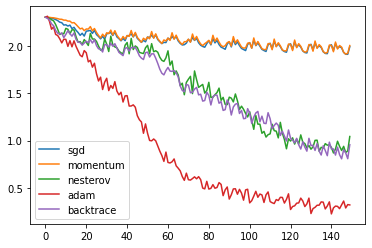

In [42]:
# Plot the training error curves for implemented optimizers
plt.plot(loss_hist_sgd, label="sgd")
plt.plot(loss_hist_momentum, label="momentum")
plt.plot(loss_hist_nesterov, label="nesterov")
plt.plot(loss_hist_adam, label="adam")
plt.plot(loss_hist_backtrace, label="backtrace")
plt.legend()
plt.show()

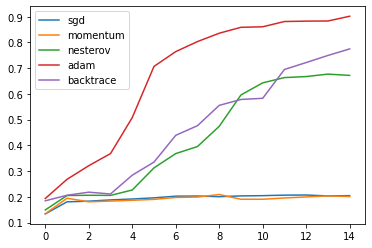

In [43]:
# Plot the training accuracy curves for implemented optimizers
plt.plot(train_acc_hist_sgd, label="sgd")
plt.plot(train_acc_hist_momentum, label="momentum")
plt.plot(train_acc_hist_nesterov, label="nesterov")
plt.plot(train_acc_hist_adam, label="adam")
plt.plot(train_acc_hist_backtrace, label="backtrace")
plt.legend()
plt.show()

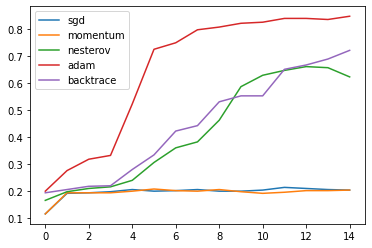

In [44]:
# Plot the validation accuracy curves for implemented optimizers
plt.plot(val_acc_hist_sgd, label="sgd")
plt.plot(val_acc_hist_momentum, label="momentum")
plt.plot(val_acc_hist_nesterov, label="nesterov")
plt.plot(val_acc_hist_adam, label="adam")
plt.plot(val_acc_hist_backtrace, label="backtrace")
plt.legend()
plt.show()

<span style="color:red">**TODO:**</span> Compare the results from above. Answer the following questions based on your observations and understandings of these optimizers:

1. Briefly conclude why each of the optimizers beats naive SGD. Which of them is the winner based on your results?
2. How does backtracing improves the naive SGD? What is the main drawback of line search that prevents its application in the optmization of deep neural networks?
3. Briefly describe another optimizer that is not introduced in this assignment.

Answer: **[fill in herer]**.
A1) Momentum smoothens optimization by accumulating gradients, helping to overcome small barriers. Nesterov Momentum anticipates future updates for faster convergence. Adam combines momentum with adaptive learning rates, adjusting based on past gradients, making it versatile and often effective without much tuning. Backtrace adaptively selects the learning rate based on the loss landscape, preventing overshooting or slow convergence. These optimizers address naive SGD's limitations, enhancing efficiency and robustness.The Adam optimizer is the winner based on my results.

A2) Backtracing refines SGD by adaptively selecting the learning rate based on the loss landscape, ensuring appropriate step sizes and preventing overshooting or slow convergence. However, the main drawback of line search in deep neural networks is its computational cost. Evaluating the loss function multiple times during each update in large networks is time-consuming and inefficient, making it impractical for deep architectures with millions of parameters.

A3) Adagrad (Adaptive Gradient Algorithm): Adagrad adapts the learning rates of all model parameters by scaling them inversely proportional to the square root of the sum of all historical squared values. This means parameters with frequent updates have their learning rate reduced, while parameters with infrequent updates have their learning rate increased. However, its continuously decreasing learning rate can become too small over time, slowing down convergence.

Formula: $\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot g_t $